In [881]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
# Import necessary libraries
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Combine Multiple files into a single file and read the data

In [882]:
# Concatenating all the files to a single file in a row wise manner
dfs = []

for i in range(12):
  month = str(i+1)

  if len(month) == 1:
    month = "0" + month

  file_path = "/content/en_climate_hourly_ON_6106001_" + month + "-2023_P1H.csv"
  df = pd.read_csv(file_path)
  dfs.append(df)

full_data= pd.concat(dfs, ignore_index=True)

In [883]:
def time_to_hour(time_str):
    # Split the time string into hours and minutes
    hours, _ = time_str.split(':')

    # Return only the hours part as an integer
    return int(hours)

In [884]:
full_data.describe()

,Longitude (x),Latitude (y),Climate ID,Year,Month,Day,Temp (°C),Temp Flag,Dew Point Temp (°C),Dew Point Temp Flag,...,Wind Spd (km/h),Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag
count,8760.00,8.760000e+03,8760.0,8760.0,8760.000000,8760.000000,8758.000000,0.0,8758.000000,0.0,...,8758.000000,0.0,8758.000000,0.0,8758.000000,0.0,1156.000000,0.0,2521.000000,0.0
mean,-75.67,4.532000e+01,6106001.0,2023.0,6.526027,15.720548,7.913645,NaN,3.140272,NaN,...,14.094314,NaN,20.864216,NaN,100.135807,NaN,29.605536,NaN,-10.919873,NaN
std,0.00,1.421167e-14,0.0,0.0,3.448048,8.796749,11.266514,NaN,10.574268,NaN,...,7.614604,NaN,6.658852,NaN,0.811130,NaN,3.549541,NaN,6.438655,NaN
min,-75.67,4.532000e+01,6106001.0,2023.0,1.000000,1.000000,-32.200000,NaN,-36.100000,NaN,...,0.000000,NaN,0.000000,NaN,96.730000,NaN,25.000000,NaN,-43.000000,NaN
25%,-75.67,4.532000e+01,6106001.0,2023.0,4.000000,8.000000,-0.800000,NaN,-4.600000,NaN,...,9.000000,NaN,24.100000,NaN,99.610000,NaN,27.000000,NaN,-14.000000,NaN
50%,-75.67,4.532000e+01,6106001.0,2023.0,7.000000,16.000000,7.800000,NaN,2.700000,NaN,...,13.000000,NaN,24.100000,NaN,100.140000,NaN,29.000000,NaN,-9.000000,NaN
75%,-75.67,4.532000e+01,6106001.0,2023.0,10.000000,23.000000,17.700000,NaN,12.600000,NaN,...,18.000000,NaN,24.100000,NaN,100.700000,NaN,32.000000,NaN,-6.000000,NaN
max,-75.67,4.532000e+01,6106001.0,2023.0,12.000000,31.000000,34.100000,NaN,23.800000,NaN,...,52.000000,NaN,24.100000,NaN,102.550000,NaN,42.000000,NaN,-1.000000,NaN


In [885]:
# Remove the cols which has only a single value or has all null values
cols = ["Longitude (x)" , "Latitude (y)" , "Station Name", "Climate ID",
        "Year" , "Temp Flag" , "Dew Point Temp Flag" , "Rel Hum Flag" , "Precip. Amount (mm)" ,
        "Precip. Amount Flag" , "Wind Dir Flag" , "Wind Spd Flag" , "Visibility Flag",
        "Stn Press Flag" , "Hmdx Flag" , "Wind Chill Flag" ]

full_data.drop(cols, axis=1, inplace=True)

In [886]:
full_data.head()

,Date/Time (LST),Month,Day,Time (LST),Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather
0,2023-01-01 00:00,1,1,00:00,3.0,3.0,100.0,28.0,11.0,0.4,99.11,NaN,NaN,Fog
1,2023-01-01 01:00,1,1,01:00,3.0,3.0,100.0,26.0,10.0,0.4,99.16,NaN,NaN,Fog
2,2023-01-01 02:00,1,1,02:00,3.0,3.0,100.0,30.0,21.0,6.4,99.22,NaN,NaN,Fog
3,2023-01-01 03:00,1,1,03:00,2.6,2.6,100.0,28.0,24.0,8.1,99.27,NaN,NaN,Fog
4,2023-01-01 04:00,1,1,04:00,2.4,2.4,100.0,28.0,23.0,11.3,99.33,NaN,NaN,Cloudy


## Preprocessing of Target Variable Weather

In [887]:
# Based on the visibiltiy we determine whether it is a good or bad weather
def classify_weather(weather_cls , visib_number):
  binary_cls = ""
  if weather_cls == "null":
    if visib_number < 18:
      binary_cls = "Bad_Weather"
    else:
      binary_cls =  "Good Weather"
    return binary_cls
  else:
    return weather_cls

# Convert it to the Binary Weather
def binary_weather(weather_cls):

  if weather_cls in good_conds:
    binary_cls = "Good Weather"
  elif weather_cls in ["Good Weather" , "Bad Weather"]:
    binary_cls = weather_cls
  else:
    binary_cls = "Bad Weather"
  return binary_cls

In [888]:
# Segregating the good weather conditions and bad weather conditions
good_conds = ["Mainly Clear" , "Clear"]

bad_conds = []

for i in full_data["Weather"].unique():
  if (i not in good_conds) and (i != np.nan):
    bad_conds.append(i)

bad_conds.remove(np.nan)

In [889]:
# Visibility threshold for bad conditions
visibiltiy_df = full_data[full_data["Weather"].isin(bad_conds)]
print(visibiltiy_df["Visibility (km)"].median())

# Median Visibility for the Good conditions
Visibility_good_df = full_data[full_data["Weather"].isin(good_conds)]
Visibility_good_df["Visibility (km)"].median()

16.1


24.1

In [890]:
full_data["Weather"] = full_data["Weather"].fillna("null")

In [891]:
full_data["Weather"] = full_data.apply(lambda row: classify_weather(row["Weather"] , row["Visibility (km)"] ) , axis=1)
full_data["Binary Weather"] = full_data["Weather"].apply(binary_weather)

In [892]:
full_data["Binary Weather"].value_counts()

Good Weather    5376
Bad Weather     3384
Name: Binary Weather, dtype: int64

In [893]:
full_data.shape

(8760, 15)

### Split the dataset into train and test

In [894]:
# Assuming X is your feature data and y is your target data
tscv = TimeSeriesSplit(n_splits=2 )  # You can change the number of splits as needed

for train_index, test_index in tscv.split(full_data):
  train_df, test_df = full_data.iloc[train_index], full_data.iloc[test_index]

In [895]:
train_df["Binary Weather"].value_counts() / train_df.shape[0]

Good Weather    0.613699
Bad Weather     0.386301
Name: Binary Weather, dtype: float64

In [896]:
test_df["Binary Weather"].value_counts() / test_df.shape[0]

Good Weather    0.613699
Bad Weather     0.386301
Name: Binary Weather, dtype: float64

## Exploratory Data Analysis

## Univariate Analysis

In [897]:
# Extract temperature column
temperature = train_df['Temp (°C)']

# Create histogram graph
fig = px.histogram(temperature, nbins=50, title='Temperature Distribution')
fig.show()

In [898]:
# Extract Dew point temperature column
dew_pt = train_df['Dew Point Temp (°C)']

# Create histogram graph
fig = px.histogram(dew_pt, nbins=50, title='Dew_Point')
fig.show()

In [899]:
# Extract Station Pressure column
Stn_press = train_df['Stn Press (kPa)']

# Create histogram graph
fig = px.histogram(Stn_press, nbins=50, title='Stn_Press')
fig.show()

In [900]:
# Extract wind chill column
Wind_Chill = train_df['Wind Chill']

# Create histogram graph
fig = px.histogram(Wind_Chill, nbins=20, title='Wind Chill')
fig.show()

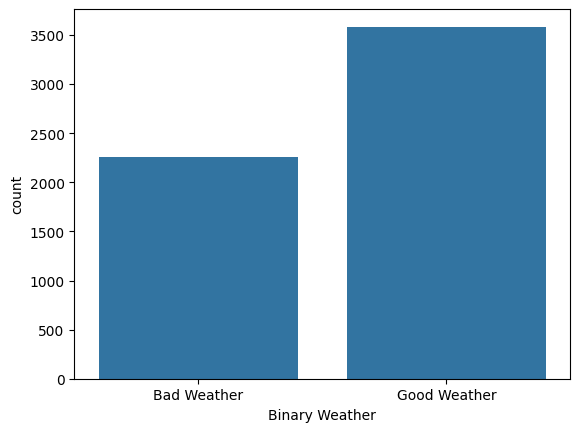

In [901]:
# Extract binary weather column
binary_weather = train_df['Binary Weather']

# Create count plot for binary weather
sns.countplot(x=binary_weather)
plt.show()

### Bivariate Distribution

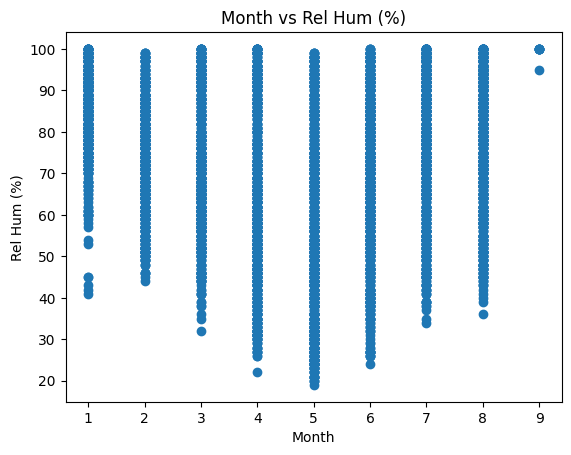

In [902]:
plt.scatter(train_df['Month'], train_df['Rel Hum (%)'])

# Adding labels to the axes
plt.xlabel('Month')
plt.ylabel('Rel Hum (%)')

# Adding a title to the plot
plt.title('Month vs Rel Hum (%)')

# Displaying the plot
plt.show()

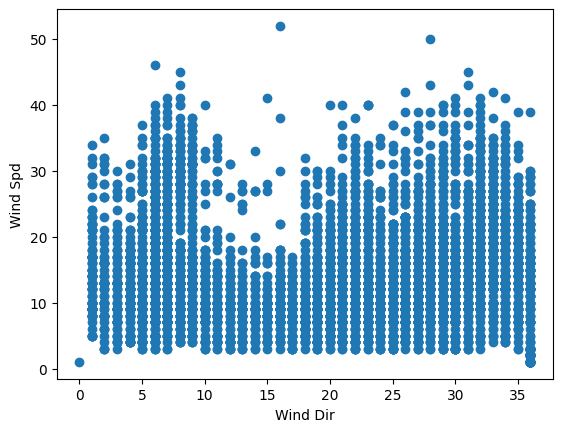

In [903]:
plt.scatter(train_df["Wind Dir (10s deg)"] , train_df["Wind Spd (km/h)"])
# Adding labels to the axes
plt.xlabel('Wind Dir')
plt.ylabel('Wind Spd')

plt.show()

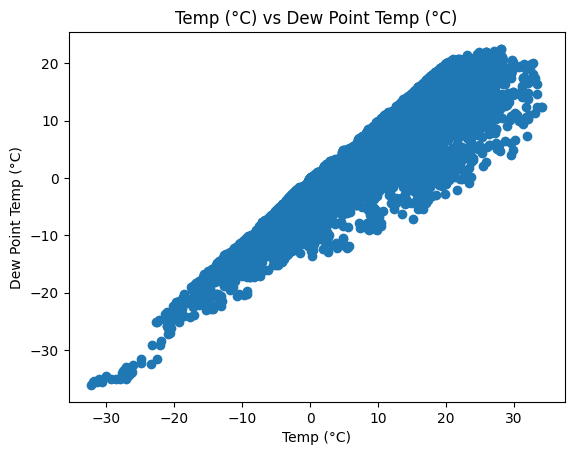

In [904]:
plt.scatter(train_df['Temp (°C)'], train_df['Dew Point Temp (°C)'])

# Adding labels to the axes
plt.xlabel('Temp (°C)')
plt.ylabel('Dew Point Temp (°C)')

# Adding a title to the plot
plt.title('Temp (°C) vs Dew Point Temp (°C)')

# Displaying the plot
plt.show()

### Box plots

In [905]:
# Create box graph for relative humidity and month
fig = px.box(full_data, x='Month', y='Rel Hum (%)', title='Box Graph for Relative Humidity by Month')
fig.show()

In [906]:
# Create box graph for visibility and Binary Weather
fig = px.box(full_data, x='Binary Weather', y='Visibility (km)', title='Box Graph for Visibility by Binary Weather')
fig.show()

In [907]:
# Create box graph for Temp and Binary Weather
fig = px.box(full_data, x='Binary Weather', y='Temp (°C)', title='Box Graph for Temp (°C) by Binary Weather')
fig.show()

In [908]:
fig = px.box(full_data, x='Binary Weather', y='Rel Hum (%)', title='Box Graph for Rel Hum (%) by Binary Weather')
fig.show()

In [909]:
# Create box graph for Relative Humidity and Binary Weather
fig = px.box(full_data, x='Binary Weather', y='Rel Hum (%)', title='Box Graph for Rel Hum (%) by Binary Weather')
fig.show()

In [910]:
# Create box graph for Station Pressure and Binary Weather
fig = px.box(full_data, x='Binary Weather', y='Stn Press (kPa)', title='Box Graph for Stn Press (kPa) by Binary Weather')
fig.show()

## HeatMap

In [911]:
# Convert the "Weather" column to a numeric column
train_df_dup = train_df.copy()
train_df_dup["Discrete Weather"] = train_df_dup["Binary Weather"].apply(lambda x: 1 if x == "Good Weather" else 0)

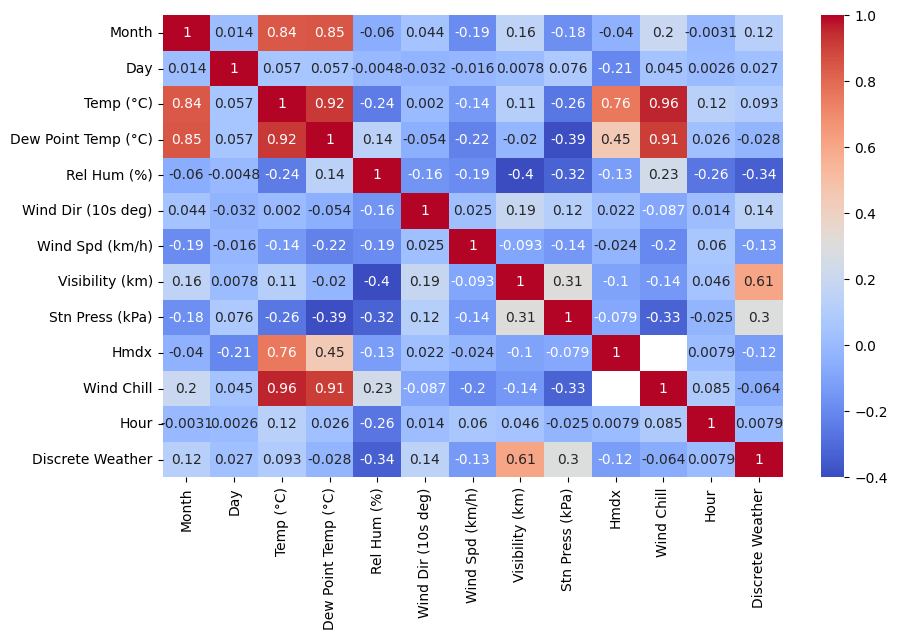

In [912]:
train_df_dup['Hour'] = train_df_dup['Time (LST)'].apply(time_to_hour)

# Calculate correlation matrix
corr_matrix = train_df_dup[['Month', 'Day', 'Temp (°C)', 'Dew Point Temp (°C)', 'Rel Hum (%)',
       'Wind Dir (10s deg)', 'Wind Spd (km/h)', 'Visibility (km)',
       'Stn Press (kPa)', 'Hmdx', 'Wind Chill','Hour' , 'Discrete Weather']].corr()

# Generate heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Preprocessing

### Filling in Missing and Null values

In [913]:
import numpy as np
from sklearn.impute import SimpleImputer

# Checking the Outliers  using Z-score method
z_scores = (train_df - train_df.mean()) / train_df.std()
threshold = 3
outliers = (np.abs(z_scores) > threshold).any(axis=1)

numeric_cols = train_df.select_dtypes(exclude="object").columns
# If there are outliers, fill them with median, otherwise fill with mean
if outliers.any():
    imputer = SimpleImputer(strategy='median')
    train_df[numeric_cols] = imputer.fit_transform(train_df[numeric_cols])
    print("Outliers detected. Filled missing values with median.")
else:
    imputer = SimpleImputer(strategy='mean')
    train_df[numeric_cols] = imputer.fit_transform(train_df[numeric_cols])
    print("No outliers detected. Filled missing values with mean.")

test_df[numeric_cols] = imputer.transform(test_df[numeric_cols])

Outliers detected. Filled missing values with median.


In [914]:
train_df.select_dtypes(exclude="object").columns

Index(['Month', 'Day', 'Temp (°C)', 'Dew Point Temp (°C)', 'Rel Hum (%)',
       'Wind Dir (10s deg)', 'Wind Spd (km/h)', 'Visibility (km)',
       'Stn Press (kPa)', 'Hmdx', 'Wind Chill'],
      dtype='object')

### Normalization

In [915]:
from sklearn.preprocessing import MinMaxScaler

norm_cols = numeric_cols[2:]

# Initialize a scaler object
scaler = MinMaxScaler()

# Fit and transform the data
train_df[norm_cols] = scaler.fit_transform(train_df[norm_cols])

# Test it on test data
test_df[norm_cols] = scaler.transform(test_df[norm_cols])

### Correct Dtypes

In [916]:
# Int copnversion dtypes
int_dtypes = ["Month" , "Day"]

for col in int_dtypes:
  train_df[col] = train_df[col].astype("int")
  test_df[col] = test_df[col].astype("int")

train_df.head()

,Date/Time (LST),Month,Day,Time (LST),Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather,Binary Weather
0,2023-01-01 00:00,1,1,00:00,0.530920,0.667235,1.0,0.777778,0.211538,0.016598,0.431159,0.266667,0.761905,Fog,Bad Weather
1,2023-01-01 01:00,1,1,01:00,0.530920,0.667235,1.0,0.722222,0.192308,0.016598,0.440217,0.266667,0.761905,Fog,Bad Weather
2,2023-01-01 02:00,1,1,02:00,0.530920,0.667235,1.0,0.833333,0.403846,0.265560,0.451087,0.266667,0.761905,Fog,Bad Weather
3,2023-01-01 03:00,1,1,03:00,0.524887,0.660410,1.0,0.777778,0.461538,0.336100,0.460145,0.266667,0.761905,Fog,Bad Weather
4,2023-01-01 04:00,1,1,04:00,0.521870,0.656997,1.0,0.777778,0.442308,0.468880,0.471014,0.266667,0.761905,Cloudy,Bad Weather


## Feature Engineering

### Extracting Hour from the Time Variable

In [917]:
# train_df_dup = train_df.copy()
train_df['Hour'] = train_df['Time (LST)'].apply(time_to_hour)
test_df['Hour'] = test_df['Time (LST)'].apply(time_to_hour)

### Determine the Season through Month

In [918]:
# Define a function to map months to seasons
train_df_dup = train_df.copy()
# Winter - 3 , spring- 0 , summer -1 , fall - 2

def map_month_to_season(month):
    if month in [12, 1, 2]:
        return 3
    elif month in [3, 4, 5]:
        return 0
    elif month in [6, 7, 8]:
        return 1
    elif month in [9, 10, 11]:
        return 2
    else:
        return 'Unknown'

# Apply the mapping function to create the 'Season' column
train_df['Season'] = train_df['Month'].apply(map_month_to_season)
test_df['Season'] = test_df['Month'].apply(map_month_to_season)

### Combination of Interaction Features

In [919]:
# This represents the vector components of wind which might provide insights into wind patterns.
train_df['Wind_Speed_Dir'] = train_df['Wind Spd (km/h)'] * train_df['Wind Dir (10s deg)']
test_df['Wind_Speed_Dir'] = test_df['Wind Spd (km/h)'] * test_df['Wind Dir (10s deg)']

# The temperature difference between the actual temperature and the dew point temperature
train_df['Temp_Diff'] = train_df['Temp (°C)'] - train_df['Dew Point Temp (°C)']
test_df['Temp_Diff'] = test_df['Temp (°C)'] * test_df['Dew Point Temp (°C)']

# A combination of temperature and relative humidity
train_df['Humidity_Index'] = train_df['Temp (°C)'] * train_df['Rel Hum (%)']
test_df['Humidity_Index'] = test_df['Temp (°C)'] * test_df['Rel Hum (%)']

# Calculate Wind Chill Factor
train_df['Wind_Chill_Factor'] = train_df['Temp (°C)'] - (0.45 * (1.6 * train_df['Wind Spd (km/h)'])**0.16)
test_df['Wind_Chill_Factor'] = test_df['Temp (°C)'] * test_df['Wind Spd (km/h)']

### Creating a Weekend and day/night feature

In [920]:
# Assuming 'Date' column exists in the format 'YYYY-MM-DD'
train_df['DateTime'] = pd.to_datetime(train_df['Date/Time (LST)'])
train_df['Day_of_Week'] = train_df['DateTime'].dt.dayofweek

test_df['DateTime'] = pd.to_datetime(test_df['Date/Time (LST)'])
test_df['Day_of_Week'] = test_df['DateTime'].dt.dayofweek

# Classify as 'Weekday' or 'Weekend'
train_df['Is_Weekend'] = train_df['Day_of_Week'].apply(lambda x: 1 if x > 4 else 0)
test_df['Is_Weekend'] = test_df['Day_of_Week'].apply(lambda x: 1 if x > 4 else 0)

### Day/Night Feature

In [921]:
# If it is between the hours between 6pm to 6am then it is night
train_df['Is_Night'] = train_df['Hour'].apply(lambda x: 1 if 18 <= x or x < 6 else 0)
test_df['Is_Night'] = test_df['Hour'].apply(lambda x: 1 if 18 <= x or x < 6 else 0)

# Convert the Categorical Binary Weather Feature to a Discrete 0 and 1s

In [922]:
# Convert the "Weather" column to a numeric column
train_df["Binary Weather"] = train_df["Binary Weather"].apply(lambda x: 1 if x == "Good Weather" else 0)
test_df["Binary Weather"] = test_df["Binary Weather"].apply(lambda x: 1 if x == "Good Weather" else 0)

In [923]:
train_df.columns

Index(['Date/Time (LST)', 'Month', 'Day', 'Time (LST)', 'Temp (°C)',
       'Dew Point Temp (°C)', 'Rel Hum (%)', 'Wind Dir (10s deg)',
       'Wind Spd (km/h)', 'Visibility (km)', 'Stn Press (kPa)', 'Hmdx',
       'Wind Chill', 'Weather', 'Binary Weather', 'Hour', 'Season',
       'Wind_Speed_Dir', 'Temp_Diff', 'Humidity_Index', 'Wind_Chill_Factor',
       'DateTime', 'Day_of_Week', 'Is_Weekend', 'Is_Night'],
      dtype='object')

In [924]:
train_df.drop(["Date/Time (LST)" , "Time (LST)" , "DateTime" , "Day_of_Week"] , axis=1 , inplace=True)
test_df.drop(["Date/Time (LST)" , "Time (LST)" , "DateTime" , "Day_of_Week"] , axis=1 , inplace=True)

# Feature Selection - deciding which feature are important

## Filter Method - Mutual Information

In [925]:
train_df.select_dtypes(exclude="object").columns

Index(['Month', 'Day', 'Temp (°C)', 'Dew Point Temp (°C)', 'Rel Hum (%)',
       'Wind Dir (10s deg)', 'Wind Spd (km/h)', 'Visibility (km)',
       'Stn Press (kPa)', 'Hmdx', 'Wind Chill', 'Binary Weather', 'Hour',
       'Season', 'Wind_Speed_Dir', 'Temp_Diff', 'Humidity_Index',
       'Wind_Chill_Factor', 'Is_Weekend', 'Is_Night'],
      dtype='object')

In [926]:
# Select the features and target variable
mutual_features = list(train_df.select_dtypes(exclude="object").columns)
mutual_features.remove("Binary Weather")

mutual_target = 'Binary Weather'

# Calculate mutual information
mutual_info = mutual_info_classif(train_df[mutual_features], train_df[mutual_target])

# Display mutual information scores for each feature
mutual_info_df = pd.DataFrame(mutual_info, index=mutual_features, columns=['Mutual Information'])
print(mutual_info_df)

                     Mutual Information
Month                          0.016995
Day                            0.016589
Temp (°C)                      0.026703
Dew Point Temp (°C)            0.037441
Rel Hum (%)                    0.063881
Wind Dir (10s deg)             0.023886
Wind Spd (km/h)                0.006770
Visibility (km)                0.250547
Stn Press (kPa)                0.038308
Hmdx                           0.001521
Wind Chill                     0.015738
Hour                           0.077070
Season                         0.012219
Wind_Speed_Dir                 0.009479
Temp_Diff                      0.073424
Humidity_Index                 0.044872
Wind_Chill_Factor              0.003785
Is_Weekend                     0.003372
Is_Night                       0.000000


In [927]:
# Sort the DataFrame by importance score in descending order
mutual_info_df = mutual_info_df.sort_values(by='Mutual Information', ascending=True)

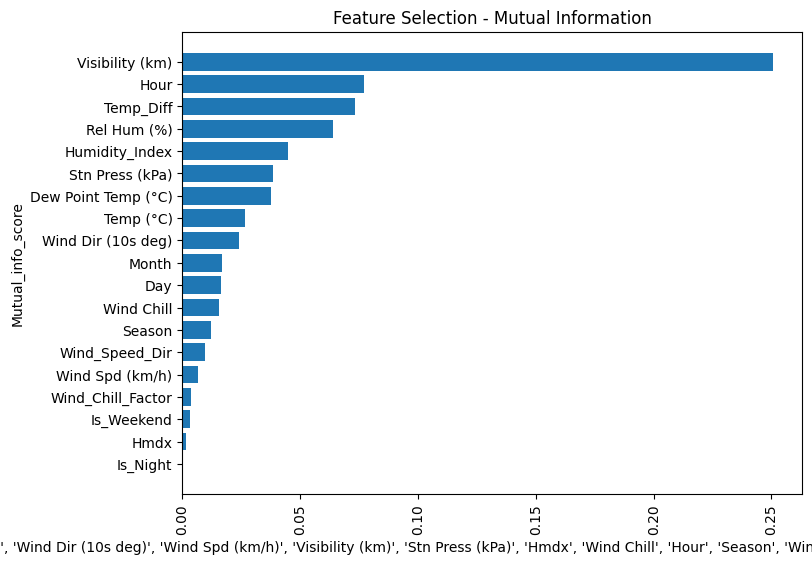

In [928]:
# Create a bar graph
plt.figure(figsize=(8,6))
plt.barh(mutual_info_df.index,mutual_info_df["Mutual Information"] )
#Declare x and y axis
plt.xlabel(mutual_features)
plt.xticks(rotation=90)
plt.ylabel('Mutual_info_score')
plt.title('Feature Selection - Mutual Information')
plt.show()

## Wrapper Method - Recursive Feature Elimination

In [929]:
train_feat = train_df.drop(["Binary Weather" , "Weather"] , axis=1)
train_target = train_df["Binary Weather"]

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the Random Forest Classifier to the training data
rf_classifier.fit(train_feat , train_target)

# Get feature importance scores
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to display feature importance scores
feature_importance_df = pd.DataFrame({'Feature': train_feat.columns, 'Importance Score': feature_importances})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance Score', ascending=False)

# Print feature importance scores
print("Feature Importance Scores:")
print(feature_importance_df)

Feature Importance Scores:
                Feature  Importance Score
7       Visibility (km)          0.293709
14            Temp_Diff          0.073166
8       Stn Press (kPa)          0.070983
11                 Hour          0.068104
15       Humidity_Index          0.060222
4           Rel Hum (%)          0.057772
16    Wind_Chill_Factor          0.057293
3   Dew Point Temp (°C)          0.049605
2             Temp (°C)          0.049087
13       Wind_Speed_Dir          0.046952
6       Wind Spd (km/h)          0.046045
5    Wind Dir (10s deg)          0.041846
1                   Day          0.028982
0                 Month          0.020486
10           Wind Chill          0.011688
18             Is_Night          0.006983
9                  Hmdx          0.006736
17           Is_Weekend          0.005574
12               Season          0.004767


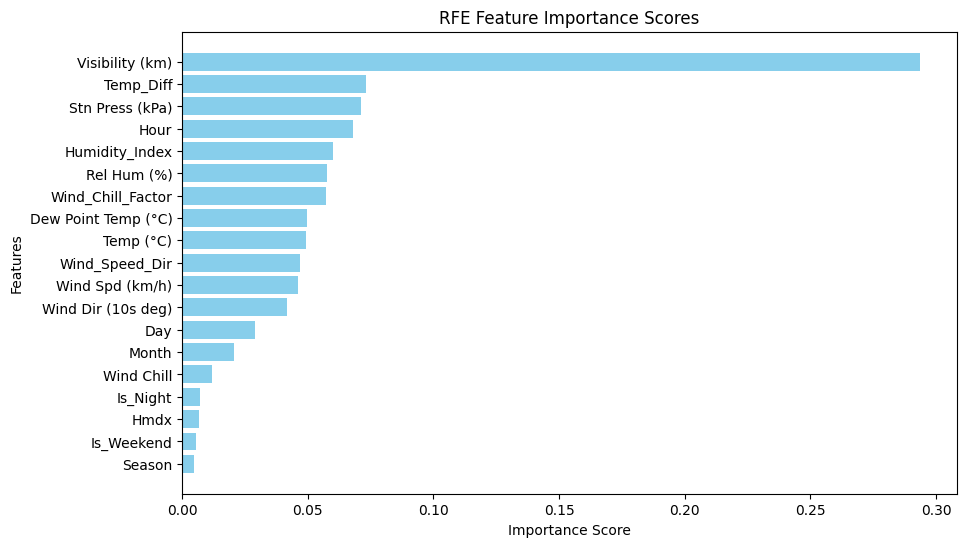

In [930]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance Score'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('RFE Feature Importance Scores')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

In [931]:
# Selected features from the feature selection
imp_feat = ["Visibility (km)" , "Rel Hum (%)" , "Hour" , "Stn Press (kPa)" , "Month" , "Temp (°C)" , "Dew Point Temp (°C)" ,
       "Wind Dir (10s deg)" , "Wind Spd (km/h)" , "Temp_Diff" , "Humidity_Index"]

# Training Algorithms

In [932]:
features = train_df.drop(["Binary Weather" , "Weather"] , axis=1)
target = train_df["Binary Weather"]

features = features[imp_feat]

In [933]:
features.to_csv("cleaned_data.csv")

In [ ]:
test_features = test_df.drop(["Binary Weather" , "Weather"] , axis=1)
test_target = test_df["Binary Weather"]

test_features = test_features[imp_feat]

## Support Vector Machine with Cross Validation

In [872]:
## Support Vector Machine Classifier
svc = SVC()

sk_folds = StratifiedKFold(n_splits = 5)
svc.fit(features  , target)

# Cross Validation scores
svm_scores = cross_val_score(svc, features , target , cv = sk_folds)

In [873]:
svm_scores

array([0.88270548, 0.78938356, 0.74400685, 0.81934932, 0.7140411 ])

## Random forest Classifier with Cross Validation

In [ ]:
# Random Forest Classifier
sk_folds = StratifiedKFold(n_splits = 5)
rf = RandomForestClassifier()
rf.fit(features , target)

rf_scores = cross_val_score(rf, features , target , cv = sk_folds)

In [ ]:
rf_scores

array([0.39469178, 0.51541096, 0.75342466, 0.75941781, 0.77739726])

In [ ]:
svm_scores_mean = svm_scores.mean()
rf_scores_mean = rf_scores.mean()

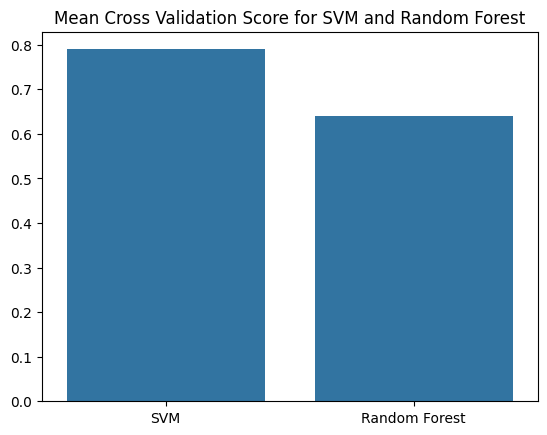

In [ ]:
sns.barplot(x=["SVM" , "Random Forest"] , y=[svm_scores_mean , rf_scores_mean])
plt.title("Mean Cross Validation Score for SVM and Random Forest")
plt.show()

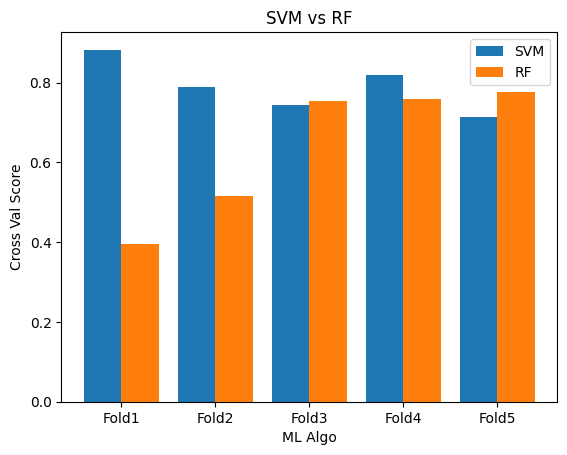

In [ ]:
X = ['Fold1','Fold2' , "Fold3" , "Fold4" , "Fold5"]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2  , svm_scores ,  0.4, label = 'SVM')
plt.bar(X_axis  + 0.2,  rf_scores , 0.4, label = 'RF')

plt.xticks(X_axis, X)
plt.xlabel("ML Algo")
plt.ylabel("Cross Val Score")
plt.title("SVM vs RF")
plt.legend()
plt.show()

## SVM Predictions

In [ ]:
y_pred = svc.predict(test_features)
print(classification_report(test_target , y_pred))

              precision    recall  f1-score   support

           0       1.00      0.25      0.40      1128
           1       0.68      1.00      0.81      1792

    accuracy                           0.71      2920
   macro avg       0.84      0.63      0.61      2920
weighted avg       0.80      0.71      0.65      2920



## RandomForest Predictions

In [ ]:
y_pred_rfc =  rf.predict(test_features)
print(classification_report(test_target , y_pred_rfc))

              precision    recall  f1-score   support

           0       0.96      0.55      0.70      1128
           1       0.78      0.99      0.87      1792

    accuracy                           0.82      2920
   macro avg       0.87      0.77      0.78      2920
weighted avg       0.85      0.82      0.80      2920



### Hyperparameter Tuning

In [ ]:
# defining Support Vector parameter range
param_grid = {'C': [0.1, 1, 10 ],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']}

svc_ht = SVC()

svc_grid = GridSearchCV(svc_ht, param_grid, scoring="accuracy", cv = 3 , verbose = 3 , n_jobs = -1)
svc_grid.fit(features , target)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=3)

In [ ]:
svc_grid.best_params_

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

In [ ]:
svc_grid.best_score_

0.7176436266791102

In [ ]:
## Tuned SVC
svc_tuned = SVC(C = 1 , gamma = 0.01 , kernel = "rbf")
svc_tuned.fit(features , target)

SVC(C=1, gamma=0.01)

In [ ]:
y_pred_svc_tune =  svc_tuned.predict(test_features)
print(classification_report(test_target , y_pred_svc_tune))

              precision    recall  f1-score   support

           0       1.00      0.27      0.42      1128
           1       0.68      1.00      0.81      1792

    accuracy                           0.72      2920
   macro avg       0.84      0.63      0.62      2920
weighted avg       0.80      0.72      0.66      2920



In [ ]:
# RandomForest Tuning Parameters
rf_param_grid = {
    'max_depth': [50 , 200 , 500 ],
    'n_estimators': [100, 300 , 500 ]
}

rf_ht = RandomForestClassifier()

rf_grid = GridSearchCV(rf_ht, rf_param_grid, scoring="accuracy", cv = 3 , verbose = 3 , n_jobs = -1)
rf_grid.fit(features , target)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [874]:
rf_grid.best_params_

{'max_depth': 50, 'n_estimators': 500}

In [875]:
rf_grid.best_score_

0.6724567077572808

In [876]:
## Tuned RFC
# rf_tuned = RandomForestClassifier(max_depth = 50 , min_samples_leaf = 3 , n_estimators = 100)
rf_tuned = RandomForestClassifier(max_depth = 50 ,  n_estimators = 500)
rf_tuned.fit(features , target)

RandomForestClassifier(max_depth=50, n_estimators=500)

In [877]:
y_pred_rfc_tune =  rf_tuned.predict(test_features)
print(classification_report(test_target , y_pred_rfc_tune))

              precision    recall  f1-score   support

           0       0.99      0.53      0.69      1128
           1       0.77      1.00      0.87      1792

    accuracy                           0.82      2920
   macro avg       0.88      0.76      0.78      2920
weighted avg       0.85      0.82      0.80      2920

